# Data analysis 

This notebook takes the filtered data from the data preparation notebook and conducts further analysis

*Author: Koki Sasagawa*  

*Date: 4/10/2019*

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import pprint

%matplotlib inline

In [2]:
files = os.listdir('./temp_data/')
for i, fname in enumerate(files):
    print(i, fname)

0 3-min-water-safety-survey-paid_April 5, 2019_13.26.csv
1 comparisons_US(full_MI).csv
2 comparisons_US(full).csv
3 comparisons_US(full_NON_MI).csv
4 comparisons(mTurk).csv
5 3-min-water-safety-survey_April 6, 2019_11.06.csv
6 comparisons.csv
7 concepts_graph_data.xlsx
8 comparisons_US(mTurk).csv
9 NON_US
10 comparisons_US.csv


In [3]:
survey = pd.read_csv('./temp_data/comparisons_US(full).csv', index_col = 0)
print(survey.shape)
survey.head(3)

(109, 33)


,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,LocationLatitude,...,Q7_5,Q7_6,Q7_6_TEXT,Q8,Q9,Q10,Q11,address,country,state
0,3/31/19 16:57,3/31/19 17:01,IP Address,35.2.149.130,100,228,True,3/31/19 17:01,R_1IK0hEA0Mide4IB,42.306793,...,Extremely Important,NaN,NaN,Between 11 to 15 cups,Sedan,Under 20 miles / under 32 km,When I stop every time!!!,"Thurston, Ann Arbor, MI, United States",USA,MI
1,3/31/19 17:02,3/31/19 17:04,IP Address,35.1.136.17,100,106,True,3/31/19 17:04,R_2AKgAVgBovymcHp,42.306793,...,Important,NaN,NaN,Between 1 to 5 cups,I do not drive,NaN,NaN,"Thurston, Ann Arbor, MI, United States",USA,MI
2,3/31/19 16:58,3/31/19 17:04,IP Address,35.1.88.101,100,397,True,3/31/19 17:04,R_1f8Jsm0KyK8p4hl,42.306793,...,Important,NaN,NaN,Between 6 to 10 cups,Sedan,Under 20 miles / under 32 km,"When I am driving, I wanna drink it","Thurston, Ann Arbor, MI, United States",USA,MI


# Analyze Q7 reponses on factors impacting water quality

In [4]:
# Check for missing values
survey.isna().sum()

StartDate                 0
EndDate                   0
Status                    0
IPAddress                 0
Progress                  0
Duration (in seconds)     0
Finished                  0
RecordedDate              0
ResponseId                0
LocationLatitude          0
LocationLongitude         0
DistributionChannel       0
UserLanguage              0
Q1                        0
Q2                        0
Q3                        0
Q4                        0
Q5                        0
Q6                        0
Q7_1                      0
Q7_2                      0
Q7_3                      0
Q7_4                      1
Q7_5                      0
Q7_6                     73
Q7_6_TEXT                89
Q8                        0
Q9                        0
Q10                      13
Q11                      18
address                   0
country                   0
state                     0
dtype: int64

We expect Q7_6, Q7_6_TEXT to have some empty responses as these were optional. Q10 and Q11 can also be expected to contain missing values as these questions were not accessible if the driver selected "I do not drive" as a response to Q9. 

Q7_4 should not be missing a response. Since there is only 1 instance of a row with missing values, we will simply omit this row from the data. 

In [5]:
# Get the row index that contains the missing response in Q7_4.
rows = survey[survey['Q7_4'].isna()].index.tolist()
rows

[70]

In [6]:
# Drop this row
# The dimension should have 1 less row than previous 
survey = survey.drop(index=rows, axis=0)
survey.reset_index(drop=True, inplace=True)
print("Dimensions: {}".format(survey.shape))

Dimensions: (108, 33)


In [7]:
Q7_responses = survey[['Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q7_6', 'Q7_6_TEXT']]
print("Dimensions: {}".format(Q7_responses.shape))

Dimensions: (108, 7)


In [8]:
Q7_responses.head()

,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Q7_6,Q7_6_TEXT
0,Important,Extremely Important,Important,Extremely Important,Extremely Important,NaN,NaN
1,Important,Extremely Important,Important,Extremely Important,Important,NaN,NaN
2,Extremely Important,Extremely Important,Important,Extremely Important,Important,NaN,NaN
3,Extremely Important,Somewhat Important,Somewhat Important,Extremely Important,Important,Important,Myths/gossip about places with better/worse water
4,Important,Somewhat Important,Somewhat Not Important,Somewhat Important,Neutral,NaN,NaN


## Analyze themes that users felt were important

In [9]:
# Separate out the free text box responses
Q7_optional = Q7_responses[['Q7_6', 'Q7_6_TEXT']]
Q7_optional.dropna(inplace=True)
print("Dimensions: {}".format(Q7_optional.shape))
Q7_optional.reset_index(drop=True, inplace=True)
Q7_optional.columns = ['Other (please specify)', 'Textbox Entry']


# sort by specified order
Q7_optional.loc[:,'Other (please specify)'] = pd.Categorical(Q7_optional['Other (please specify)'], categories=['Extremely Important', 
                                                                                                          'Important',
                                                                                                          'Somewhat Important',
                                                                                                          'Neutral',
                                                                                                          'Somewhat Not Important',
                                                                                                          'Not Important',
                                                                                                          'Extremely Not Important'])
# sort
Q7_optional = Q7_optional.sort_values('Other (please specify)')
Q7_optional

Dimensions: (17, 2)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,Other (please specify),Textbox Entry
1,Extremely Important,sustainability
13,Extremely Important,water ph
3,Extremely Important,Water taste.
4,Extremely Important,Whether the water was filtered/treated or not
9,Extremely Important,Taste
0,Important,Myths/gossip about places with better/worse water
12,Important,"if it is bottled, how old it is"
10,Important,Taste
16,Important,Taste
6,Important,Source depletion


## Analyze how factors compared rank among eachother

In [10]:
Q7_responses[Q7_responses[['Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5']] == 'Extremely Important'].count()

Q7_1         34
Q7_2         57
Q7_3         39
Q7_4         67
Q7_5         38
Q7_6          0
Q7_6_TEXT     0
dtype: int64

In [11]:
# Rank by highest number of extrememly important
# Local water pollution level
# Testing of water quality
# Government Water regulations
# News Impacting Water Safety
# Water Source

factors = Q7_responses[['Q7_4', 'Q7_2', 'Q7_3', 'Q7_5', 'Q7_1']]
factors.columns = ['Local water pollution level', 'Testing of water quality', 'Gov. water regulations', 
                   'News Impacting Water Safety', 'Water Source']


factors.reset_index(drop=True, inplace=True)
print(factors.shape)
factors.head()

(108, 5)


,Local water pollution level,Testing of water quality,Gov. water regulations,News Impacting Water Safety,Water Source
0,Extremely Important,Extremely Important,Important,Extremely Important,Important
1,Extremely Important,Extremely Important,Important,Important,Important
2,Extremely Important,Extremely Important,Important,Important,Extremely Important
3,Extremely Important,Somewhat Important,Somewhat Important,Important,Extremely Important
4,Somewhat Important,Somewhat Important,Somewhat Not Important,Neutral,Important


In [12]:
for i in factors.columns:
    factors.loc[:,i] = factors[i].map({"Extremely Important": 7,
                                       "Important": 6,
                                       "Somewhat Important": 5,
                                       "Neutral": 4,
                                       "Somewhat Not Important": 3,
                                       "Not Important": 2,
                                       "Extremely Not Important": 1})

print(factors.shape)
factors.head()

(108, 5)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Local water pollution level,Testing of water quality,Gov. water regulations,News Impacting Water Safety,Water Source
0,7,7,6,7,6
1,7,7,6,6,6
2,7,7,6,6,7
3,7,5,5,6,7
4,5,5,3,4,6


In [15]:
# Generate subplot grid coordinates
axis_keys = np.arange(5)

In [16]:
# Map column to grid coordinates
subplot_data = {}
for i, v in enumerate(factors):
    subplot_data[v] = axis_keys[i]

subplot_data

{'Local water pollution level': 0,
 'Testing of water quality': 1,
 'Gov. water regulations': 2,
 'News Impacting Water Safety': 3,
 'Water Source': 4}

In [17]:
colors = ['deepskyblue', 'lightgreen', 'coral', 'gold', 'plum']

6.425925925925926
6.194444444444445
5.962962962962963
5.953703703703703
5.796296296296297


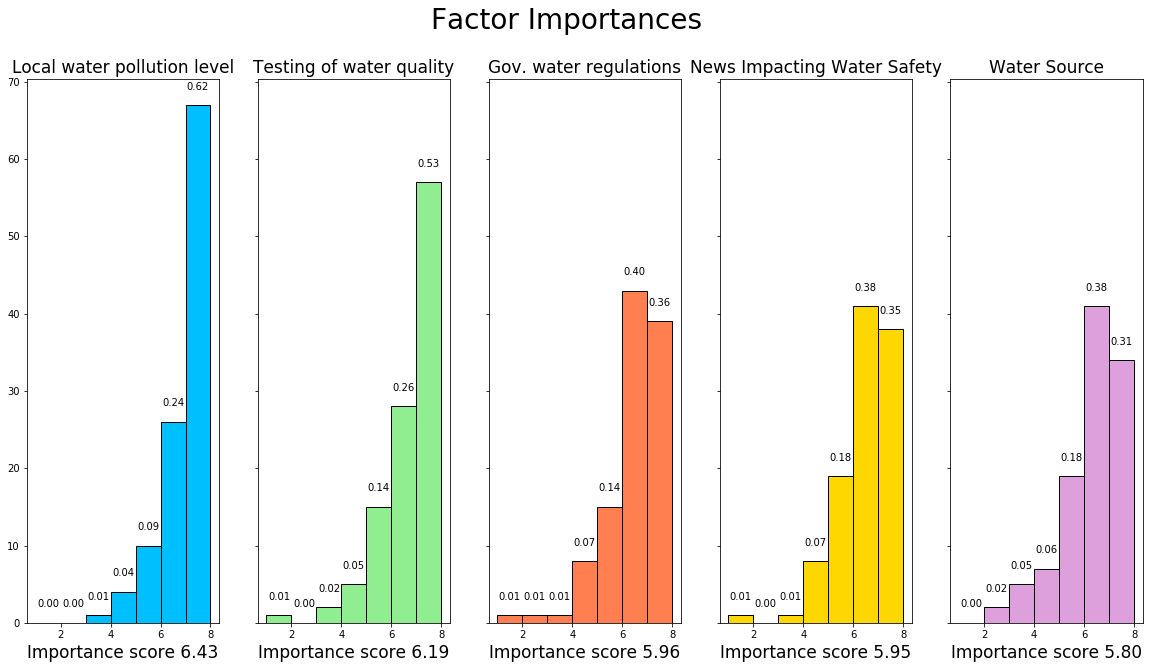

In [19]:
fig, ax = plt.subplots(figsize=(20,10), nrows=1, ncols=5, sharey=True)
fig.suptitle('Factor Importances', fontsize=28)

for k, v in subplot_data.items():
    ax[v].hist(factors[k], bins=np.arange(1,9), range=(1,7),
               histtype='bar', color=colors[v], edgecolor='black')
    ax[v].set_title(k, fontsize=17)
    
    y = [] 
    for rects in ax[v].patches:
        # y-axis value 
        height = rects.get_height()
        y.append(height)
        ax[v].text(rects.get_x()+rects.get_width()/2.0,
                   height+2, 
                   '{:1.2f}'.format(height/factors.shape[0]),
                   ha='center')
    
    # weighted average using frequency of each ranking
    pos_score = np.average(np.array([1,2,3,4,5,6,7]), weights=np.array(y))
    print(pos_score)
#    pos_score = sum(y[-3:])/factors.shape[0]
    ax[v].set_xlabel('Importance score {:1.2f}'.format(pos_score), fontsize=17)


fig = plt.gcf() 
# fig.savefig("./images/Factors.png")
plt.show()

In [20]:
e_important = []
important = [] 
s_important = []
neutral = []
s_n_important = []
n_important = []
e_n_important = []

x = factors.columns 

for i in factors.columns:
    values = dict(factors[i].value_counts())
    e_important.append(values.get(7,0))
    important.append(values.get(6,0))
    s_important.append(values.get(5,0))
    neutral.append(values.get(4,0))
    s_n_important.append(values.get(3,0))
    n_important.append(values.get(2,0))
    e_n_important.append(values.get(1,0))

In [21]:
print("Extremely Important", e_important) 
print("Important", important)
print("Somewhat Important", s_important)
print('Neutral', neutral)
print('Somewhat Not Important', s_n_important)
print('Not Important', n_important)
print('Extremely Not Important', e_n_important)

Extremely Important [67, 57, 39, 38, 34]
Important [26, 28, 43, 41, 41]
Somewhat Important [10, 15, 15, 19, 19]
Neutral [4, 5, 8, 8, 7]
Somewhat Not Important [1, 2, 1, 1, 5]
Not Important [0, 0, 1, 0, 2]
Extremely Not Important [0, 1, 1, 1, 0]


In [22]:
total = [sum(x) for x in zip(e_important,important, s_important)]
total

[103, 100, 97, 98, 94]

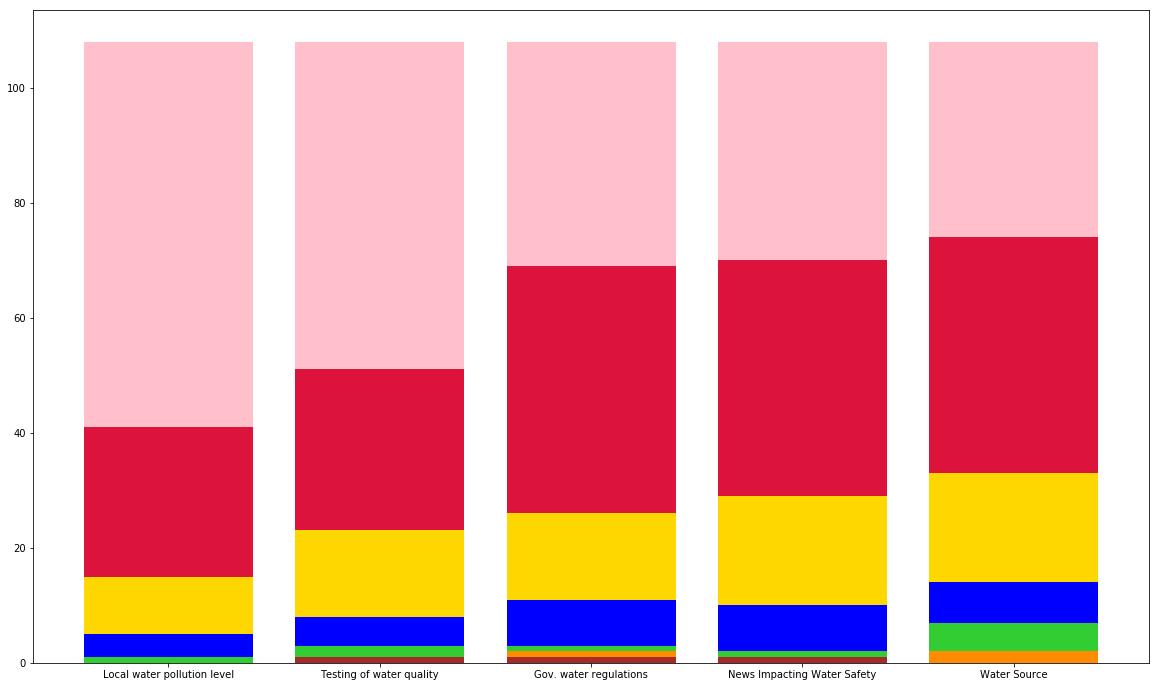

In [23]:
plt.figure(figsize=(20,12))
plt.bar(x, e_n_important, color='brown')
plt.bar(x, n_important, bottom=e_n_important, color='darkorange')
plt.bar(x, s_n_important, bottom=[sum(x) for x in zip(n_important, e_n_important)], color='limegreen')
plt.bar(x, neutral, bottom=[sum(x) for x in zip(s_n_important, n_important, e_n_important)], color='blue')
plt.bar(x, s_important, bottom=[sum(x) for x in zip(neutral, s_n_important, n_important, e_n_important)], color='gold')
plt.bar(x, important, bottom=[sum(x) for x in zip(s_important, neutral, s_n_important, n_important, e_n_important)], color='crimson')
plt.bar(x, e_important, bottom=[sum(x) for x in zip(important, s_important, neutral, s_n_important, n_important, e_n_important)], color='pink')
fig = plt.gcf()
# fig.savefig('./images/stacked_barplot.pdf')

## Analyze Free text responsese and extract concepts (Q11)

The free text responses were analyzed by manually coding each response. Concepts were created and counted during the process. The coded table can be located in the file "survey_q11_analysis.csv"

### Concept Graph

In [24]:
# Initialize graph
G = nx.Graph()

# read data
concepts = pd.read_excel("./temp_data/concepts_graph_data.xlsx", dtype={'ID': int,
                                                                        'Edges': str,
                                                                        'Edge Attribute': str})
print("Dimensions: {}".format(concepts.shape))
concepts.head()

Dimensions: (17, 5)


,ID,Node Attribute 1,Node Attribute 2,Edges,Edge Attribute
0,1,long distance travel,29,"3, 9, 2, 8, 5, 10, 7, 16, 15","2, 3, 5, 1, 1, 2, 1, 1, 1"
1,2,hydration,20,"3, 1, 6, 5, 7, 10, 16, 8","7, 5, 1, 2, 2, 1, 1, 1"
2,3,water bottle,11,"2, 1, 8, 9","7, 2, 1, 1"
3,4,never,11,"5, 14","3, 2"
4,5,skepticism,8,"2, 4, 1, 14","2, 3, 1, 2"


### Add nodes

In [25]:
# Add nodes
node_list = concepts['ID'].tolist()
G.add_nodes_from(node_list)
print("Number of nodes added: {}".format(G.number_of_nodes()))
print(G.nodes)

Number of nodes added: 17
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


### Add edges

In [26]:
# Find rows with nan values 
exclusion = []
for i,v in enumerate(concepts.isna().sum(axis=1).values):
    if v > 0:
        exclusion.append(i)
        print("index to drop: {}".format(i))

index to drop: 10
index to drop: 12
index to drop: 16


In [27]:
edges = concepts.drop(index=exclusion)[['ID', 'Edges', 'Edge Attribute']]
print("Dimensions: {}".format(edges.shape))
edges

Dimensions: (14, 3)


,ID,Edges,Edge Attribute
0,1,"3, 9, 2, 8, 5, 10, 7, 16, 15","2, 3, 5, 1, 1, 2, 1, 1, 1"
1,2,"3, 1, 6, 5, 7, 10, 16, 8","7, 5, 1, 2, 2, 1, 1, 1"
2,3,"2, 1, 8, 9","7, 2, 1, 1"
3,4,"5, 14","3, 2"
4,5,"2, 4, 1, 14","2, 3, 1, 2"
5,6,"12, 2","1, 1"
6,7,"2, 10, 1","2, 1, 1"
7,8,"1, 3, 2","1, 1, 1"
8,9,"1, 3","3, 1"
9,10,"7, 1, 2","1, 2, 1"


In [28]:
edge_list = []
for target_nodes in edges['Edges']:
    if len(target_nodes) > 1:
        target_nodes = re.sub(',', '', target_nodes).split()
        edge_list.append(target_nodes)
    else:
        edge_list.append(target_nodes)

pprint.pprint(edge_list)

[['3', '9', '2', '8', '5', '10', '7', '16', '15'],
 ['3', '1', '6', '5', '7', '10', '16', '8'],
 ['2', '1', '8', '9'],
 ['5', '14'],
 ['2', '4', '1', '14'],
 ['12', '2'],
 ['2', '10', '1'],
 ['1', '3', '2'],
 ['1', '3'],
 ['7', '1', '2'],
 '6',
 ['4', '5'],
 '1',
 '1']


In [29]:
node_edge_pairs = []

for index, source_node in enumerate(edges['ID']):
    node_edge_pairs = node_edge_pairs + [(int(source_node), int(target_node)) for target_node in edge_list[index]]

node_edge_pairs

[(1, 3),
 (1, 9),
 (1, 2),
 (1, 8),
 (1, 5),
 (1, 10),
 (1, 7),
 (1, 16),
 (1, 15),
 (2, 3),
 (2, 1),
 (2, 6),
 (2, 5),
 (2, 7),
 (2, 10),
 (2, 16),
 (2, 8),
 (3, 2),
 (3, 1),
 (3, 8),
 (3, 9),
 (4, 5),
 (4, 14),
 (5, 2),
 (5, 4),
 (5, 1),
 (5, 14),
 (6, 12),
 (6, 2),
 (7, 2),
 (7, 10),
 (7, 1),
 (8, 1),
 (8, 3),
 (8, 2),
 (9, 1),
 (9, 3),
 (10, 7),
 (10, 1),
 (10, 2),
 (12, 6),
 (14, 4),
 (14, 5),
 (15, 1),
 (16, 1)]

In [30]:
G.add_edges_from(node_edge_pairs)

In [31]:
G.edges

EdgeView([(1, 3), (1, 9), (1, 2), (1, 8), (1, 5), (1, 10), (1, 7), (1, 16), (1, 15), (2, 3), (2, 6), (2, 5), (2, 7), (2, 10), (2, 16), (2, 8), (3, 8), (3, 9), (4, 5), (4, 14), (5, 14), (6, 12), (7, 10)])

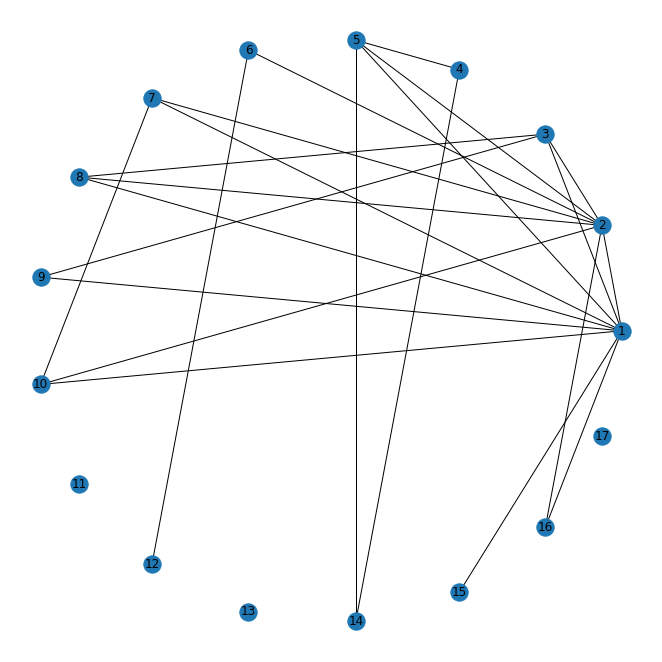

In [32]:
# Nodes without any edges: 11, 13, 17
plt.figure(1, figsize=(9,9))
pos = nx.shell_layout(G)
nx.draw(G, pos, with_labels=True)
# plt.savefig('./images/concept_map_skeleton.pdf', bbox_inches="tight")
plt.show()

### Add node attributes

In [33]:
attributes = {}
# {1: {'name': 'hydration', 'count': 20} ...
names = concepts['Node Attribute 1'].tolist()
counts = concepts['Node Attribute 2'].tolist()

# Create nested dictionary of attributes
for i in range(0, concepts.shape[0]):
    layer = {'name': names[i],
             'count': counts[i]}
    attributes[i+1] = layer
    
pprint.pprint(attributes)

{1: {'count': 29, 'name': 'long distance travel'},
 2: {'count': 20, 'name': 'hydration'},
 3: {'count': 11, 'name': 'water bottle'},
 4: {'count': 11, 'name': 'never'},
 5: {'count': 8, 'name': 'skepticism'},
 6: {'count': 6, 'name': 'outdoors'},
 7: {'count': 4, 'name': 'last choice'},
 8: {'count': 4, 'name': 'commute'},
 9: {'count': 4, 'name': 'uninterrupted drive'},
 10: {'count': 3, 'name': 'hot weather'},
 11: {'count': 3, 'name': 'other'},
 12: {'count': 3, 'name': 'emergency'},
 13: {'count': 2, 'name': 'stopping'},
 14: {'count': 2, 'name': 'misunderstanding'},
 15: {'count': 2, 'name': 'morning'},
 16: {'count': 2, 'name': 'passengers'},
 17: {'count': 1, 'name': 'conservation'}}


In [34]:
nx.set_node_attributes(G, attributes)

# Check that attributes were added 
print('Name of node (ID 1): {}'.format(G.nodes[1]['name']))
print('Number of counts (ID 1): {}'.format(G.nodes[1]['count']))
print('Name of node (ID 10): {}'.format(G.nodes[10]['name']))
print('Number of counts (ID 10): {}'.format(G.nodes[10]['count']))

Name of node (ID 1): long distance travel
Number of counts (ID 1): 29
Name of node (ID 10): hot weather
Number of counts (ID 10): 3


### Add edge attributes

In [35]:
edge_attributes = []
for attr in edges['Edge Attribute']:
    if len(attr) > 1: 
        attr = re.sub(',', '', attr).split()
        edge_attributes.append(attr)
    else:
        edge_attributes.append([attr])

print("Size: {}".format(len(edge_attributes)))
pprint.pprint(edge_attributes)

Size: 14
[['2', '3', '5', '1', '1', '2', '1', '1', '1'],
 ['7', '5', '1', '2', '2', '1', '1', '1'],
 ['7', '2', '1', '1'],
 ['3', '2'],
 ['2', '3', '1', '2'],
 ['1', '1'],
 ['2', '1', '1'],
 ['1', '1', '1'],
 ['3', '1'],
 ['1', '2', '1'],
 ['1'],
 ['2', '2'],
 ['1'],
 ['1']]


In [37]:
all_edge_attributes = []
for i in edge_attributes:
    all_edge_attributes = all_edge_attributes + i

print("Size: ", len(all_edge_attributes), ' ', all_edge_attributes)
print("Size: ", len(node_edge_pairs), ' ', node_edge_pairs)

Size:  45   ['2', '3', '5', '1', '1', '2', '1', '1', '1', '7', '5', '1', '2', '2', '1', '1', '1', '7', '2', '1', '1', '3', '2', '2', '3', '1', '2', '1', '1', '2', '1', '1', '1', '1', '1', '3', '1', '1', '2', '1', '1', '2', '2', '1', '1']
Size:  45   [(1, 3), (1, 9), (1, 2), (1, 8), (1, 5), (1, 10), (1, 7), (1, 16), (1, 15), (2, 3), (2, 1), (2, 6), (2, 5), (2, 7), (2, 10), (2, 16), (2, 8), (3, 2), (3, 1), (3, 8), (3, 9), (4, 5), (4, 14), (5, 2), (5, 4), (5, 1), (5, 14), (6, 12), (6, 2), (7, 2), (7, 10), (7, 1), (8, 1), (8, 3), (8, 2), (9, 1), (9, 3), (10, 7), (10, 1), (10, 2), (12, 6), (14, 4), (14, 5), (15, 1), (16, 1)]


In [38]:
# Create nested dictionary of edge attributes
attributes2 = {}
for i, v in enumerate(node_edge_pairs):
    layer = {'cooccurence': int(all_edge_attributes[i])}
    attributes2[v] = layer

attributes2

{(1, 3): {'cooccurence': 2},
 (1, 9): {'cooccurence': 3},
 (1, 2): {'cooccurence': 5},
 (1, 8): {'cooccurence': 1},
 (1, 5): {'cooccurence': 1},
 (1, 10): {'cooccurence': 2},
 (1, 7): {'cooccurence': 1},
 (1, 16): {'cooccurence': 1},
 (1, 15): {'cooccurence': 1},
 (2, 3): {'cooccurence': 7},
 (2, 1): {'cooccurence': 5},
 (2, 6): {'cooccurence': 1},
 (2, 5): {'cooccurence': 2},
 (2, 7): {'cooccurence': 2},
 (2, 10): {'cooccurence': 1},
 (2, 16): {'cooccurence': 1},
 (2, 8): {'cooccurence': 1},
 (3, 2): {'cooccurence': 7},
 (3, 1): {'cooccurence': 2},
 (3, 8): {'cooccurence': 1},
 (3, 9): {'cooccurence': 1},
 (4, 5): {'cooccurence': 3},
 (4, 14): {'cooccurence': 2},
 (5, 2): {'cooccurence': 2},
 (5, 4): {'cooccurence': 3},
 (5, 1): {'cooccurence': 1},
 (5, 14): {'cooccurence': 2},
 (6, 12): {'cooccurence': 1},
 (6, 2): {'cooccurence': 1},
 (7, 2): {'cooccurence': 2},
 (7, 10): {'cooccurence': 1},
 (7, 1): {'cooccurence': 1},
 (8, 1): {'cooccurence': 1},
 (8, 3): {'cooccurence': 1},
 (8, 

In [39]:
G.edges

EdgeView([(1, 3), (1, 9), (1, 2), (1, 8), (1, 5), (1, 10), (1, 7), (1, 16), (1, 15), (2, 3), (2, 6), (2, 5), (2, 7), (2, 10), (2, 16), (2, 8), (3, 8), (3, 9), (4, 5), (4, 14), (5, 14), (6, 12), (7, 10)])

In [40]:
nx.set_edge_attributes(G, attributes2)

# Check that attributes were added 
print('Co-occurence between long distance travel and hydration {}'.format(G[1][2]['cooccurence']))

Co-occurence between long distance travel and hydration 5


### Plot with attributes

In [41]:
node_attr = nx.get_node_attributes(G, 'name')
node_attr

{1: 'long distance travel',
 2: 'hydration',
 3: 'water bottle',
 4: 'never',
 5: 'skepticism',
 6: 'outdoors',
 7: 'last choice',
 8: 'commute',
 9: 'uninterrupted drive',
 10: 'hot weather',
 11: 'other',
 12: 'emergency',
 13: 'stopping',
 14: 'misunderstanding',
 15: 'morning',
 16: 'passengers',
 17: 'conservation'}

In [42]:
edge_weights = nx.get_edge_attributes(G, 'cooccurence')
edge_weights

{(1, 3): 2,
 (1, 9): 3,
 (1, 2): 5,
 (1, 8): 1,
 (1, 5): 1,
 (1, 10): 2,
 (1, 7): 1,
 (1, 16): 1,
 (1, 15): 1,
 (2, 3): 7,
 (2, 6): 1,
 (2, 5): 2,
 (2, 7): 2,
 (2, 10): 1,
 (2, 16): 1,
 (2, 8): 1,
 (3, 8): 1,
 (3, 9): 1,
 (4, 5): 3,
 (4, 14): 2,
 (5, 14): 2,
 (6, 12): 1,
 (7, 10): 1}

In [43]:
edge_weights.update((x, y*5) for x, y in edge_weights.items())
edge_weights

{(1, 3): 10,
 (1, 9): 15,
 (1, 2): 25,
 (1, 8): 5,
 (1, 5): 5,
 (1, 10): 10,
 (1, 7): 5,
 (1, 16): 5,
 (1, 15): 5,
 (2, 3): 35,
 (2, 6): 5,
 (2, 5): 10,
 (2, 7): 10,
 (2, 10): 5,
 (2, 16): 5,
 (2, 8): 5,
 (3, 8): 5,
 (3, 9): 5,
 (4, 5): 15,
 (4, 14): 10,
 (5, 14): 10,
 (6, 12): 5,
 (7, 10): 5}

In [44]:
node_size = nx.get_node_attributes(G, 'count')
node_size

{1: 29,
 2: 20,
 3: 11,
 4: 11,
 5: 8,
 6: 6,
 7: 4,
 8: 4,
 9: 4,
 10: 3,
 11: 3,
 12: 3,
 13: 2,
 14: 2,
 15: 2,
 16: 2,
 17: 1}

In [45]:
node_size.update((x, y*800) for x,y in node_size.items())
node_size

{1: 23200,
 2: 16000,
 3: 8800,
 4: 8800,
 5: 6400,
 6: 4800,
 7: 3200,
 8: 3200,
 9: 3200,
 10: 2400,
 11: 2400,
 12: 2400,
 13: 1600,
 14: 1600,
 15: 1600,
 16: 1600,
 17: 800}

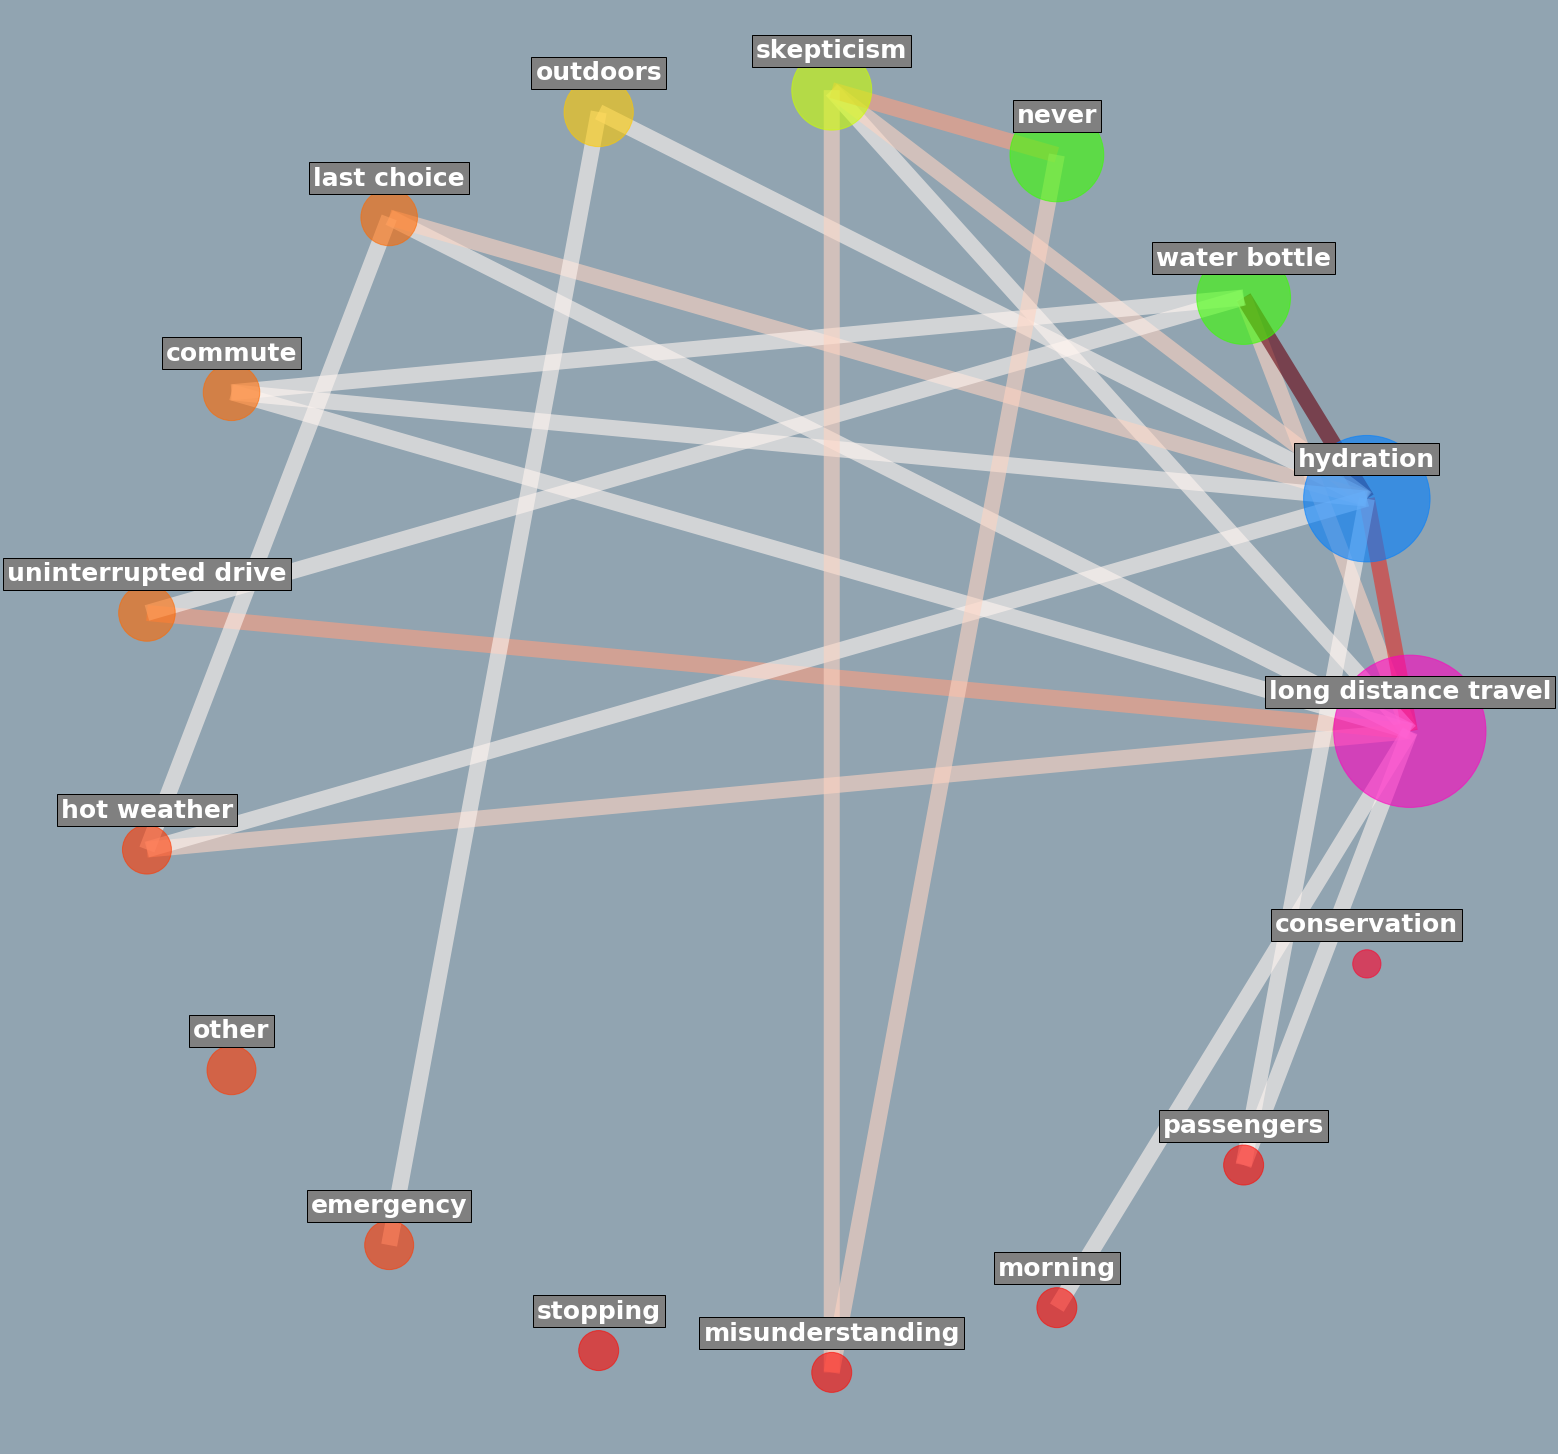

In [46]:
fig = plt.figure(2, figsize=(20,20))
pos = nx.shell_layout(G)

# Shifted coordinates for custom labels 
pos_higher = {}
for k,v in pos.items():
    pos_higher[k] = (v[0], v[1]+0.05)

# Explicitly state node and edges
nodes_id = list(G.nodes())
edges_id = list(G.edges())

nx.draw(G, pos, node_list=nodes_id, 
        node_size=list(node_size.values()),
        edges=edges_id,
        edge_color=list(edge_weights.values()),
        width=16.0,
        edge_cmap=plt.cm.Reds,
        node_color=list(node_size.values()),
        cmap='gist_rainbow',
        alpha=0.6)

# Change background color
fig.set_facecolor('#91A4B1')

# add node labels 
for k, v in pos_higher.items():
    plt.text(x=v[0], y=v[1], s=node_attr[k], bbox=dict(facecolor='grey'), fontsize=25,
             weight='bold', horizontalalignment='center', color='white')

# plt.savefig('./images/concept_map_3.pdf', facecolor=fig.get_facecolor(), bbox_inches="tight")
plt.show()